# Random Forest Classification - Ensemble (Bagging)
Create multiple trees in parallel and takes voting at end

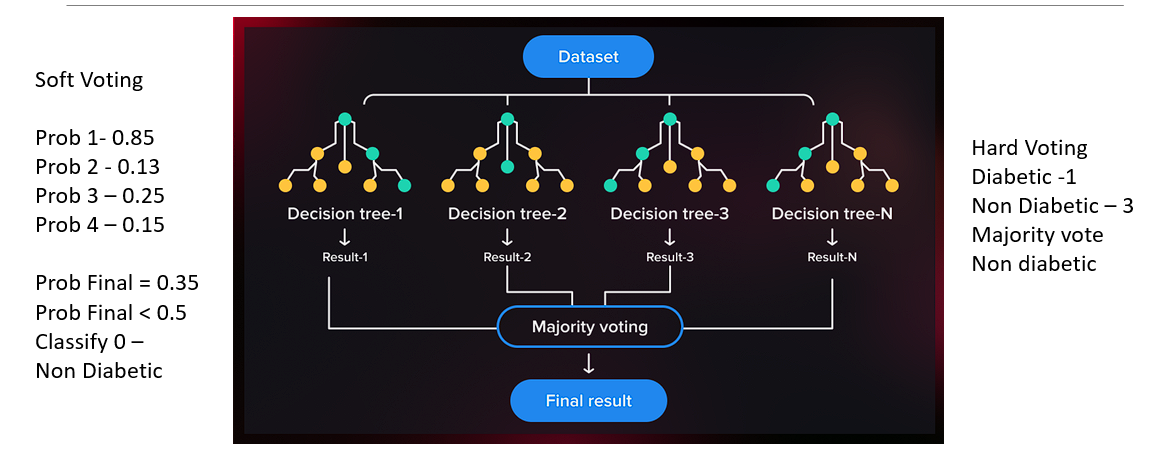

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

## Step 1 : Read the train dataset

In [6]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.shape

(891, 12)

## Step 2: Perform basic data quality checks

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
s = df.isna().sum()
s[s>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [10]:
df.duplicated().sum()

0

## Step 3: Separate X and Y features
Our target feature Y is to predict the survival of passengers from titanic

In [11]:
X = df.drop(columns=['PassengerId','Survived','Name','Ticket','Cabin'])
Y = df[['Survived']]

In [12]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [13]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [14]:
Y.value_counts()

Survived
0           549
1           342
Name: count, dtype: int64

<Axes: xlabel='Survived'>

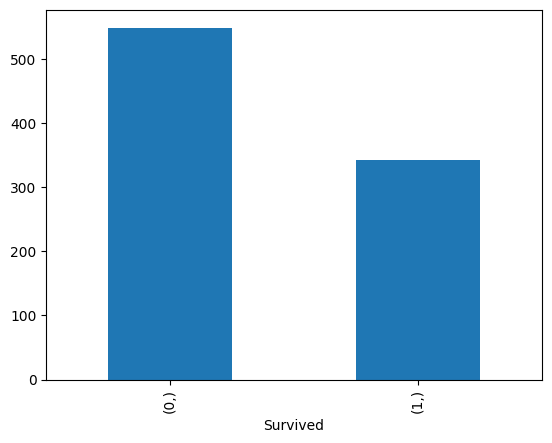

In [15]:
Y.value_counts().plot(kind='bar')

We can note from the graph that persons survied are less than half of the total persons boarded titanic

## Step 4 : Build pipeline for data preprocessing

In [16]:
# categorical and conitnuous feature separation
cat = X.columns[X.dtypes=='object']
con = X.columns[X.dtypes!='object']

In [17]:
cat

Index(['Sex', 'Embarked'], dtype='object')

In [18]:
con

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

In [20]:
num_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='mean')),
                           ('scaler',StandardScaler())])

In [21]:
cat_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])

In [22]:
pre = ColumnTransformer([('num',num_pipe,con),
                         ('cat',cat_pipe,cat)]).set_output(transform='pandas')

In [23]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Sex', 'Embarked'], dtype='object'))])

In [24]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


## Step 5: Train test split

In [25]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre,Y,test_size=0.2,random_state=21)

In [26]:
xtrain.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
793,-1.566107,0.000000,-0.474545,-0.473674,-0.030371,0.0,1.0,1.0,0.0,0.0
23,-1.566107,-0.130754,-0.474545,-0.473674,0.066360,0.0,1.0,0.0,0.0,1.0
97,-1.566107,-0.515526,-0.474545,0.767630,0.627278,0.0,1.0,1.0,0.0,0.0
9,-0.369365,-1.208115,0.432793,-0.473674,-0.042956,1.0,0.0,1.0,0.0,0.0
157,0.827377,0.023154,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


In [27]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [28]:
xtest.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
617,0.827377,-0.284663,0.432793,-0.473674,-0.324253,1.0,0.0,0.0,0.0,1.0
379,0.827377,-0.823344,-0.474545,-0.473674,-0.491874,0.0,1.0,0.0,0.0,1.0
725,0.827377,-0.746389,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
826,0.827377,0.000000,-0.474545,-0.473674,0.489104,0.0,1.0,0.0,0.0,1.0
450,-0.369365,0.484880,0.432793,2.008933,-0.089684,0.0,1.0,0.0,0.0,1.0


In [29]:
xtest.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
617,0.827377,-0.284663,0.432793,-0.473674,-0.324253,1.0,0.0,0.0,0.0,1.0
379,0.827377,-0.823344,-0.474545,-0.473674,-0.491874,0.0,1.0,0.0,0.0,1.0
725,0.827377,-0.746389,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
826,0.827377,0.000000,-0.474545,-0.473674,0.489104,0.0,1.0,0.0,0.0,1.0
450,-0.369365,0.484880,0.432793,2.008933,-0.089684,0.0,1.0,0.0,0.0,1.0


## Step 6: Model Building
### Ensemble - Bagging - Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators=1,
                                criterion='gini',
                                min_samples_split=5,
                                min_samples_leaf=5,
                                max_depth=1)
model1.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=1, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1)

In [31]:
model1.score(xtrain,ytrain)

0.6671348314606742

In [32]:
model1.score(xtest,ytest)

0.6703910614525139

### Hyperparameter tuning

In [47]:
params = {'n_estimators':[10,50,100,200,300,500],
          'min_samples_split':[2,3,4,5,6,7],
          'min_samples_leaf': [5,6,7,8,9,10],
          'criterion':['gini','entropy'],
          'max_depth':[2,3,4,5,6,7,8]}

In [48]:
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestClassifier()
rscv = RandomizedSearchCV(rfc,param_distributions=params,cv=5,scoring='f1_macro')
rscv.fit(xtrain,ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [5, 6, 7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500]},
                   scoring='f1_macro')

In [49]:
rscv.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_depth': 5,
 'criterion': 'entropy'}

In [50]:
best_rfc = rscv.best_estimator_
best_rfc

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=7,
                       n_estimators=300)

In [51]:
best_rfc.score(xtrain,ytrain)

0.8469101123595506

In [52]:
best_rfc.score(xtest,ytest)

0.8212290502793296

## Predict results for Random Forest

In [53]:
ypred_train = best_rfc.predict(xtrain)
ypred_test = best_rfc.predict(xtest)

In [54]:
ypred_train[:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [55]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [56]:
ypred_test[:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [57]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


## Plot confusion Matrix for random forest

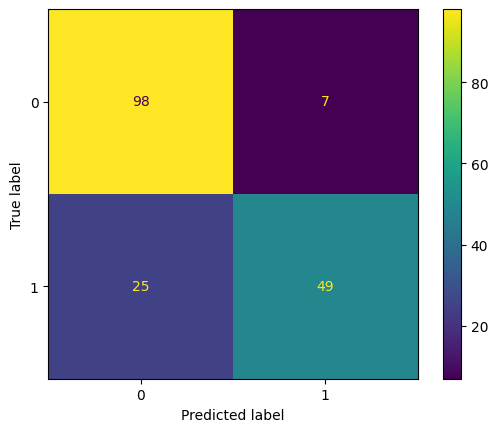

In [58]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(ytest,ypred_test)
cfd = ConfusionMatrixDisplay(cf , display_labels=best_rfc.classes_)
cfd.plot()

## Print classification report for RandomForest

In [59]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred_test))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       105
           1       0.88      0.66      0.75        74

    accuracy                           0.82       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.83      0.82      0.82       179



## Above model is a good model